Kształt danych wejściowych: (24130, 472)
Wagi klas (0: <=50K, 1: >50K): {0: 0.6674226918183327, 1: 1.993226499256567}
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7276 - loss: 0.5390 - val_accuracy: 0.8061 - val_loss: 0.3958
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8082 - loss: 0.3966 - val_accuracy: 0.8185 - val_loss: 0.3638
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8183 - loss: 0.3688 - val_accuracy: 0.8150 - val_loss: 0.3618
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8255 - loss: 0.3574 - val_accuracy: 0.8061 - val_loss: 0.3696
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8256 - loss: 0.3490 - val_accuracy: 0.8168 - val_loss: 0.3647
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8286 - loss: 0.3440 - val_accuracy: 0.8116 - val_loss: 0.3679
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8326 - loss: 0.3377 - val_accuracy: 0.8168 - val

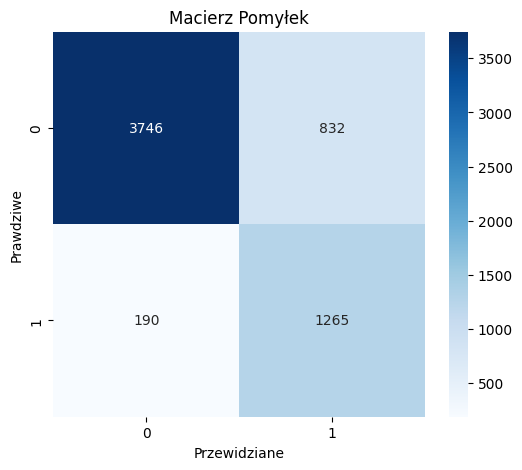

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------
# 1. WCZYTANIE DANYCH (Wersja naprawiona z nagłówkami)
# ---------------------------------------------------------
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 
           'marital.status', 'occupation', 'relationship', 'race', 'sex', 
           'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

# Wczytanie z usuwaniem spacji
df = pd.read_csv('adult.csv', names=columns, na_values='?', skipinitialspace=True)

# Usunięcie braków danych
df = df.dropna()

# ---------------------------------------------------------
# 2. PREPROCESSING (Inżynieria Cech)
# ---------------------------------------------------------
# Usuwamy zbędne kolumny
df = df.drop(['fnlwgt', 'education'], axis=1)

# Mapowanie celu: >50K = 1, <=50K = 0
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# One-Hot Encoding dla zmiennych kategorycznych
df = pd.get_dummies(df, drop_first=True)

# Podział X i y
X = df.drop('income', axis=1).values
y = df['income'].values

# Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Kształt danych wejściowych: {X_train.shape}")

# ---------------------------------------------------------
# 3. OBLICZANIE WAG KLAS (Dla zbalansowania uczenia)
# ---------------------------------------------------------
# Sieć dostanie "karę" za błędną klasyfikację mniejszości (>50K)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(weights))
print(f"Wagi klas (0: <=50K, 1: >50K): {class_weights_dict}")

# ---------------------------------------------------------
# 4. BUDOWA MODELU (Architektura 'Pro')
# ---------------------------------------------------------
model = Sequential()

# Nowoczesna definicja wejścia (usuwa ostrzeżenie Keras)
model.add(Input(shape=(X_train.shape[1],)))

# Warstwy ukryte
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Wyjście
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ---------------------------------------------------------
# 5. TRENING
# ---------------------------------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights_dict,  # <--- TU UŻYWAMY WAG
    verbose=1
)

# ---------------------------------------------------------
# 6. ZAPISYWANIE MODELU
# ---------------------------------------------------------
# Zapisujemy całą sieć (architekturę + wagi) do pliku
model_filename = 'moj_model_adult.keras'
model.save(model_filename)
print(f"\n✅ Model został zapisany jako plik: {model_filename}")

# ---------------------------------------------------------
# 7. EWALUACJA
# ---------------------------------------------------------
predictions = (model.predict(X_test) > 0.5).astype("int32")

print("\n--- Raport Klasyfikacji (z Ważeniem Klas) ---")
print(classification_report(y_test, predictions))

# Macierz pomyłek
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz Pomyłek')
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time  # <--- NOWOŚĆ: Biblioteka do mierzenia czasu

# ML & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

# TensorFlow / Keras
import tensorflow as tf
# Zamiast: from tensorflow.keras.models import Sequential, load_model
from keras.models import Sequential, load_model

# Zamiast: from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.layers import Input, Dense, Dropout, BatchNormalization

# Zamiast: from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping

# Zamiast: from tensorflow.keras.backend import clear_session
from keras.backend import clear_session

# ---------------------------------------------------------
# KONFIGURACJA
# ---------------------------------------------------------
LICZBA_PROB = 200  # <--- Zmień to po pierwszym teście czasu!
MODEL_FILENAME = 'najlepszy_model_adult.keras'

# ---------------------------------------------------------
# 1. PRZYGOTOWANIE DANYCH (To robimy raz, przed pętlą)
# ---------------------------------------------------------
print("⏳ Wczytywanie i przetwarzanie danych...")
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 
           'marital.status', 'occupation', 'relationship', 'race', 'sex', 
           'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

df = pd.read_csv('adult.csv', names=columns, na_values='?', skipinitialspace=True)
df = df.dropna()
df = df.drop(['fnlwgt', 'education'], axis=1)
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)
df = pd.get_dummies(df, drop_first=True)

X = df.drop('income', axis=1).values
y = df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Wagi klas
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))

print("✅ Dane gotowe. Rozpoczynamy pętlę treningową.")
print("-" * 60)

# ---------------------------------------------------------
# 2. PĘTLA TRENINGOWA Z LICZNIKIEM CZASU
# ---------------------------------------------------------

best_accuracy = 0.0
best_trial = 0
total_start_time = time.time() # Czas startu całego eksperymentu

for i in range(LICZBA_PROB):
    trial_start_time = time.time() # <--- Start stopera dla tej próby
    
    print(f"\n🔄 Próba {i+1}/{LICZBA_PROB}...", end=" ")
    
    clear_session()
    
    # Budowa modelu
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Trening (verbose=0, żeby nie śmiecić)
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        class_weight=class_weights_dict,
        verbose=0
    )
    
    # Ewaluacja
    predictions_temp = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
    current_acc = accuracy_score(y_test, predictions_temp)
    
    # Obliczenie czasu trwania tej próby
    trial_end_time = time.time()
    duration = trial_end_time - trial_start_time
    minutes = int(duration // 60)
    seconds = int(duration % 60)
    
    print(f"Zakończona w: {minutes}m {seconds}s | Acc: {current_acc*100:.2f}%")
    
    # Logika rekordu
    if current_acc > best_accuracy:
        print(f"   🔥 NOWY REKORD! (Poprzedni: {best_accuracy*100:.2f}%) -> Zapisuję model.")
        best_accuracy = current_acc
        best_trial = i + 1
        model.save(MODEL_FILENAME)
    else:
        print(f"   (Słabszy niż rekord {best_accuracy*100:.2f}%)")

# ---------------------------------------------------------
# 3. PODSUMOWANIE
# ---------------------------------------------------------
total_end_time = time.time()
total_duration = total_end_time - total_start_time
t_min = int(total_duration // 60)
t_sec = int(total_duration % 60)

print("-" * 60)
print(f"🏁 Koniec eksperymentu.")
print(f"⏱️ Całkowity czas pracy: {t_min}m {t_sec}s")
print(f"👑 Najlepszy model: Próba {best_trial} z wynikiem {best_accuracy*100:.2f}%")
print(f"💾 Zapisano w pliku: {MODEL_FILENAME}")

# Raport z najlepszego
best_model = load_model(MODEL_FILENAME)
predictions = (best_model.predict(X_test, verbose=0) > 0.5).astype("int32")

print("\n--- Raport dla Zwycięskiego Modelu ---")
print(classification_report(y_test, predictions))

⏳ Wczytywanie i przetwarzanie danych...
✅ Dane gotowe. Rozpoczynamy pętlę treningową.
------------------------------------------------------------

🔄 Próba 1/200... Zakończona w: 0m 19s | Acc: 83.81%
   🔥 NOWY REKORD! (Poprzedni: 0.00%) -> Zapisuję model.

🔄 Próba 2/200... Zakończona w: 0m 31s | Acc: 83.16%
   (Słabszy niż rekord 83.81%)

🔄 Próba 3/200... Zakończona w: 0m 23s | Acc: 84.25%
   🔥 NOWY REKORD! (Poprzedni: 83.81%) -> Zapisuję model.

🔄 Próba 4/200... Zakończona w: 0m 20s | Acc: 82.53%
   (Słabszy niż rekord 84.25%)

🔄 Próba 5/200... Zakończona w: 0m 35s | Acc: 83.84%
   (Słabszy niż rekord 84.25%)

🔄 Próba 6/200... Zakończona w: 0m 35s | Acc: 82.91%
   (Słabszy niż rekord 84.25%)

🔄 Próba 7/200... Zakończona w: 0m 25s | Acc: 83.62%
   (Słabszy niż rekord 84.25%)

🔄 Próba 8/200... Zakończona w: 0m 33s | Acc: 83.24%
   (Słabszy niż rekord 84.25%)

🔄 Próba 9/200... Zakończona w: 0m 18s | Acc: 84.25%
   (Słabszy niż rekord 84.25%)

🔄 Próba 10/200... Zakończona w: 0m 24s | Acc:

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


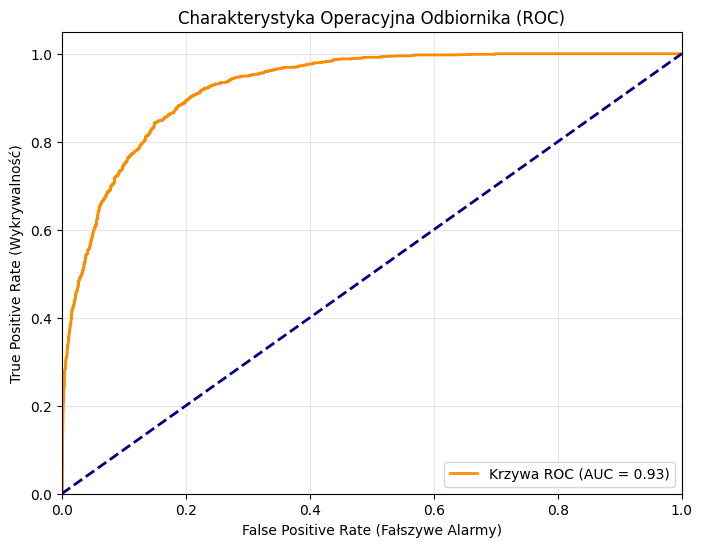

In [9]:
from sklearn.metrics import roc_curve, auc

# 1. Obliczamy prawdopodobieństwa dla klasy 1
y_pred_prob = best_model.predict(X_test).ravel()

# 2. Obliczamy punkty do krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Rysujemy wykres
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Linia losowego zgadywania
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fałszywe Alarmy)')
plt.ylabel('True Positive Rate (Wykrywalność)')
plt.title('Charakterystyka Operacyjna Odbiornika (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# 1. Ładujemy Twój zwycięski model (upewnij się co do nazwy pliku!)
FILENAME = 'najlepszy_model_adult_200_prob.keras'
loaded_model = load_model(FILENAME)
print(f"✅ Załadowano model: {FILENAME}")

# 2. Wybieramy 10 losowych osób ze zbioru testowego
random_indices = np.random.choice(len(X_test), 10, replace=False)
sample_X = X_test[random_indices]
sample_y = y_test[random_indices]

# 3. Robimy predykcję
predictions = loaded_model.predict(sample_X, verbose=0)

# 4. Wyświetlamy wyniki w ładnej tabelce
print(f"\n{'='*60}")
print(f"{'Prawdziwa Klasa':<20} | {'Prawdopodobieństwo':<20} | {'Decyzja Modelu'}")
print(f"{'='*60}")

for real, prob in zip(sample_y, predictions):
    probability = prob[0]
    prediction = ">50K" if probability > 0.5 else "<=50K"
    real_label = ">50K" if real == 1 else "<=50K"
    
    # Kolorowanie wyniku (jeśli terminal obsługuje) lub po prostu tekst
    match = "✅" if prediction == real_label else "❌"
    
    print(f"{real_label:<20} | {probability:.4f} ({probability*100:.1f}%)  | {prediction} {match}")

print(f"{'='*60}")

✅ Załadowano model: najlepszy_model_adult_200_prob.keras

Prawdziwa Klasa      | Prawdopodobieństwo   | Decyzja Modelu
<=50K                | 0.0953 (9.5%)  | <=50K ✅
<=50K                | 0.1649 (16.5%)  | <=50K ✅
<=50K                | 0.0926 (9.3%)  | <=50K ✅
<=50K                | 0.5088 (50.9%)  | >50K ❌
<=50K                | 0.1154 (11.5%)  | <=50K ✅
<=50K                | 0.6715 (67.1%)  | >50K ❌
<=50K                | 0.4447 (44.5%)  | <=50K ✅
>50K                 | 0.1398 (14.0%)  | <=50K ❌
<=50K                | 0.2099 (21.0%)  | <=50K ✅
<=50K                | 0.0765 (7.7%)  | <=50K ✅
